## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy import stats

## Импорт данных

In [2]:
data_path = "https://raw.githubusercontent.com/a-milenkin/mipt_data_science_2021/main/data/people_data_clustering.csv"
data = pd.read_csv(data_path, index_col=False)
print("Размеры датасета", data.shape)
data.head()

Размеры датасета (6000, 10)


,id,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
0,0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579


**Про Датасет**
    
Датасет представляет собой информацию по жителям некоторого города.

- was_married - Был ли когда-либо женат/замужем
- children - Количество детей
- salary - Уровень зарплаты
- sex - Пол (0 - женщина, 1 - мужчина)
- age - Возраст
- home_cost - Сумарная стоимость жилья/недвижимости
- Professon - Профессия
- drive_info - Есть ли водительские права
- happyness - уровень счастья по результатам опроса
    

**Чистка датасета**
- Удалим дубликаты и выбросы

In [3]:
data.duplicated().sum() # no duplicates

0

In [4]:
data.dropna(axis=1, inplace = True) # remove columns with nan values

In [ ]:
q75 = np.percentile(data.home_cost, 75)  # определяем 75 перцентиль
q25 = np.percentile(data.home_cost, 25)  # определяем 25 перцентиль
intr_qr = q75-q25                        # определяем межквартильный диапазон
max = q75+(1.5*intr_qr)                  # оцениваем верхнюю границу
min = q25-(1.5*intr_qr)                  # оцениваем нижнюю границу

for x in ['home_cost']:                  # для каждой строки из home_cost
    data.loc[data[x] < min,x] = np.nan   # присвоение знания nan значениям ниже min
    data.loc[data[x] > max,x] = np.nan   # присвоение знания nan значениям выше max

In [5]:
data.dropna(inplace = True) # удаляем выбросы

In [6]:
data.shape # удалили 13 выбросов

(6000, 9)

# Проверим некоторые гипотезы

**Проверим, правда ли между Homemaker, Marketing, Healthcare и Executive в среднем  зарплаты не отличаются между собой?**

In [7]:
df_task1 = data.loc[data['profession'].isin(['Homemaker', 'Marketing', 'Healthcare', 'Executive'])] # select categories

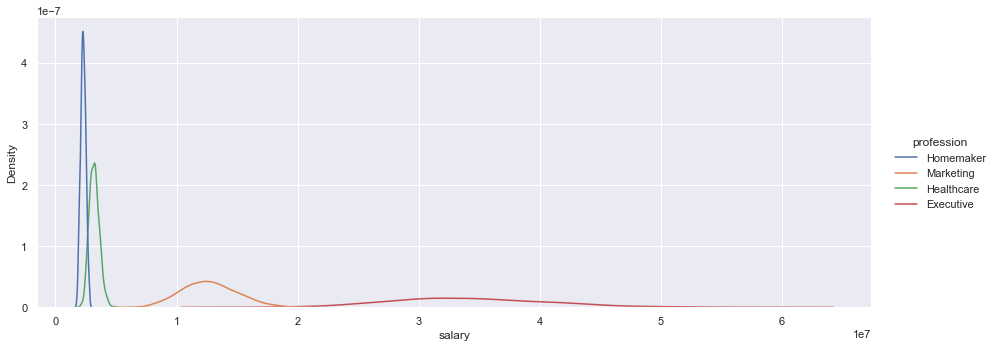

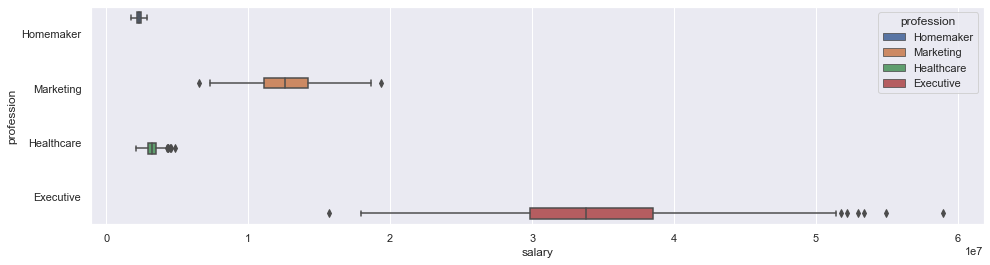

In [8]:
# Гистограммы со сглаживанием
sns.displot(df_task1, x="salary", hue="profession", height=5, aspect=2.5, kind="kde");

# Бокс-плоты
plt.figure(figsize=(16, 4))
sns.boxplot(data=df_task1, y="profession", x="salary", hue="profession");

С помощью теста Шапиро-Уилка проверим на нормальность распределения:

In [9]:
professions = df_task1.profession.unique()
for i in professions:
    temp_df = df_task1.loc[df_task1['profession'] == i].salary    
    stat, p_value = stats.shapiro(temp_df)
    alpha = 0.05
    if p_value > alpha:
      print(f'Распределение {i} нормальное')
    else:  
      print(f'Распределение {i} не нормальное')
    print(f'p-value = {round(p_value,3)}') 

Распределение Homemaker не нормальное
p-value = 0.05
Распределение Marketing не нормальное
p-value = 0.042
Распределение Healthcare не нормальное
p-value = 0.001
Распределение Executive не нормальное
p-value = 0.001


Как видим все 4 распределения не являются нормальными, поэтому используем Критерий Краскела — Уоллиса

In [10]:
Homemaker = data[data["profession"] == "Homemaker"].salary
Marketing = data[data["profession"] == "Marketing"].salary
Healthcare = data[data["profession"] == "Healthcare"].salary
Executive = data[data["profession"] == "Executive"].salary

In [11]:
statistic, pvalue = stats.kruskal(Healthcare, Homemaker, Marketing, Executive)

print(f'statistic = {round(statistic,3)}, p-value = {round(pvalue,3)}')
alpha = 0.05
if pvalue > alpha:  # Интерпретируем результат
    print("Одинаковое распределение (не отвергаем H0)")
else:
    print("Разное распределение (отклоняем H0)")
    print("Выборки отличаются статистически значимо")

statistic = 2494.363, p-value = 0.0
Разное распределение (отклоняем H0)
Выборки отличаются статистически значимо


* Зарплаты выбранных категорий отличаются и это отличие статистически значимо



**Проверим отличаются ли в среднем  зарплаты между Doctor, Entertainment и Lawyer?**

In [12]:
df_task2 = data.loc[data['profession'].isin(['Doctor', 'Entertainment', 'Lawyer'])] # select categories

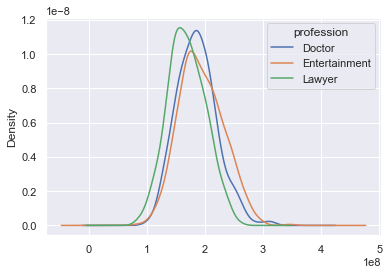

In [13]:
df_task2[['profession','salary']].pivot(index = None, columns='profession', values='salary').plot.kde();

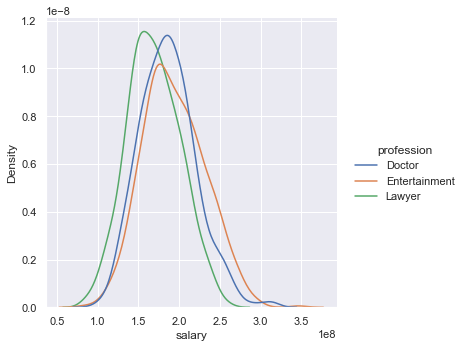

In [14]:
# Гистограммы со сглаживанием
sns.displot(df_task2, x="salary", hue="profession", kind = 'kde', common_norm = False);

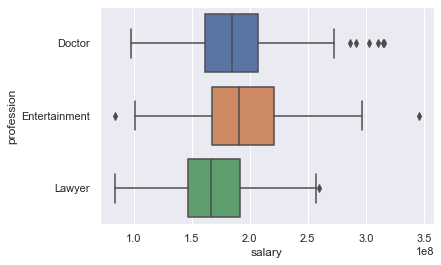

In [15]:
sns.boxplot(data=df_task2, y="profession", x="salary");

In [16]:
professions = df_task2.profession.unique() 
for i in professions: # проверка на нормальность
    temp_df = df_task2.loc[df_task2['profession'] == i].salary    
    stat, p_value = stats.shapiro(temp_df)
    alpha = 0.05
    if p_value > alpha:
      print(f'Распределение {i} нормальное')
    else:  
      print(f'Распределение {i} не нормальное')
    print(f'p-value = {round(p_value,3)}') 

Распределение Doctor не нормальное
p-value = 0.0
Распределение Entertainment не нормальное
p-value = 0.003
Распределение Lawyer нормальное
p-value = 0.092


Только 1 распределение нормальное, поэтому снова применяем критерий Краскелла-
Уолисса

In [17]:
Doctor = data[data["profession"] == "Doctor"].salary
Entertainment = data[data["profession"] == "Entertainment"].salary
Lawyer = data[data["profession"] == "Lawyer"].salary

In [18]:
statistic, pvalue = stats.kruskal(Doctor, Entertainment, Lawyer)

print(f'statistic = {round(statistic,3)}, p-value = {round(pvalue,3)}')
alpha = 0.05
if pvalue > alpha:  # Интерпретируем результат
    print("Одинаковое распределение (не отвергаем H0)")
else:
    print("Разные распределения (отклоняем H0)")
    print("Выборки отличаются статистически значимо")

statistic = 151.845, p-value = 0.0
Разные распределения (отклоняем H0)
Выборки отличаются статистически значимо


* Несмотря на похожесть визуально, распределения статистически значимо различаются





**Допустим мы рассматриваем 4 группы населения, отличающихся количеством детей. Группы следующие.**
 - A - нет детей
 - B - 1 ребенок
 - C - от 2 до 4 детей
 - D - от 5 детей    
      
      
 **Проверим отличаются ли по уровню дохода и уровню счастья эти группы?**

In [19]:
data['number_children'] = pd.cut(data.children, 
       bins=[-1, 0, 1, 4, 9], 
       labels=['0', '1', '2-4','more_5']) # добавляем столбец количества детей number_children     

Начнем с уровня дохода


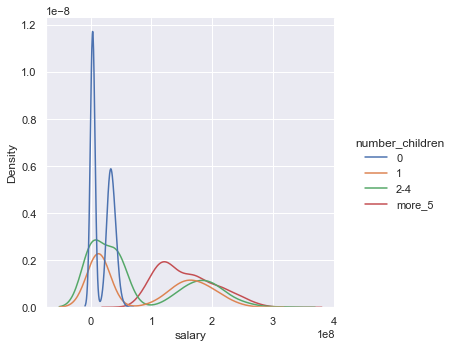

In [20]:
sns.displot(data, x="salary", hue="number_children", kind='kde');# распределения далеки от нормальных, сразу переходим к параметру Краскелла-Уоллиса

<AxesSubplot:xlabel='salary', ylabel='number_children'>

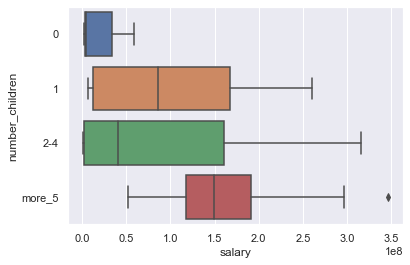

In [21]:
sns.boxplot(data=data, y="number_children", x="salary")

In [22]:
zero = data[data["number_children"] == "0"].salary
one = data[data["number_children"] == "1"].salary
two_four = data[data["number_children"] == "2-4"].salary
more_5 = data[data["number_children"] == "more_5"].salary

In [23]:
statistic, pvalue = stats.kruskal(zero, one, two_four, more_5)

print(f'statistic = {round(statistic,3)}, p-value = {round(pvalue,3)}')
alpha = 0.05
if pvalue > alpha:  # Интерпретируем результат
    print("Одинаковое распределение (не отвергаем H0)")
else:
    print("Разные распределения (отклоняем H0)")
    print("Выборки отличаются статистически значимо")

statistic = 1746.575, p-value = 0.0
Разные распределения (отклоняем H0)
Выборки отличаются статистически значимо


Перейдем к уровню счастья

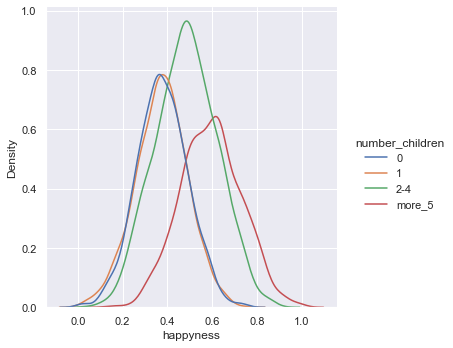

In [24]:
sns.displot(data, x="happyness", hue="number_children", kind='kde')

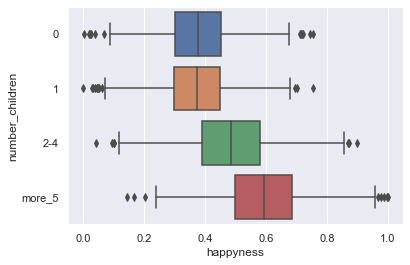

In [25]:
sns.boxplot(data=data, y="number_children", x="happyness");

In [26]:
numbers_children = data.number_children.unique() 
for i in numbers_children: # проверка на нормальность
    temp_df = data.loc[data['number_children'] == i].happyness    
    stat, p_value = stats.shapiro(temp_df)
    alpha = 0.05
    if p_value > alpha:
      print(f'Распределение {i} нормальное')
    else:  
      print(f'Распределение {i} не нормальное')
    print(f'p-value = {round(p_value,3)}') 

Распределение 2-4 нормальное
p-value = 0.084
Распределение more_5 нормальное
p-value = 0.447
Распределение 1 нормальное
p-value = 0.21
Распределение 0 нормальное
p-value = 0.743


Все распределения нормальные, можем применять дисперсионный анализ

In [27]:
statistic, pvalue = stats.f_oneway(zero, one, two_four, more_5)

print(f'statistic = {round(statistic,3)}, p-value = {round(pvalue,3)}')
alpha = 0.05
if pvalue > alpha:  # Интерпретируем результат
    print("Одинаковое распределение (не отвергаем H0)")
else:
    print("Разные распределения (отклоняем H0)")
    print("Выборки отличаются статистически значимо")

statistic = 1020.316, p-value = 0.0
Разные распределения (отклоняем H0)
Выборки отличаются статистически значимо


Да, группы статистически значимо различаются как по уровню дохода, так и по уровню счастья